## **MOFA: Microbial Optimization without Forced Altruism**


**Install Cobra Toolbox, Ipopt solver,....**

In [ ]:
!pip install cobra
import cobra
from cobra.io import load_model,read_sbml_model
import pandas as pd
import re
import sys
if "google.colab" in sys.modules:
    !wget "https://raw.githubusercontent.com/IDAES/idaes-pse/main/scripts/colab_helper.py"
    import colab_helper
    colab_helper.install_idaes()
    colab_helper.install_ipopt()

In [ ]:
from cobra import Model
from cobra.util.solver import linear_reaction_coefficients
import copy

def merge_models_block_diagonal(model1, model2, prefix2="m2_"):
    """
    Merge two COBRA models with NO shared metabolites or reactions.
    Reactions and metabolites of model2 are appended after model1.
    """


    m1 = model1.copy()
    m2 = model2.copy()

    # ---------- rename metabolites of model2 ----------
    for met in m2.metabolites:
        met.id =  met.id + prefix2

    # ---------- rename reactions of model2 ----------
    for rxn in m2.reactions:
        rxn.id =  rxn.id + prefix2

    # ---------- add metabolites ----------
    m1.add_metabolites(m2.metabolites)

    # ---------- add reactions ----------
    m1.add_reactions(m2.reactions)


    return m1

**Merge the metabolic models of species in a community to build the community meta-stoichiometric matrix.**

In [ ]:
from cobra.util.array import create_stoichiometric_matrix
import numpy as np
from cobra import Model, Reaction, Metabolite

def add_model_to_community(model, communitymodel, species_id):

  EX_1 = [i for i, rxn in enumerate(model.reactions) if 'EX_' in rxn.id]
  EX_2 = [i for i, rxn in enumerate(communitymodel.reactions) if 'EX_' in rxn.id]

  i1, _ = np.where(create_stoichiometric_matrix(model)[:, EX_1] != 0)
# community model
  i2, _ = np.where(create_stoichiometric_matrix(communitymodel)[:, EX_2] != 0)


  mets_1 = {
    met.id
    for rxn in model.reactions if 'EX_' in rxn.id
    for met in rxn.metabolites
  }
  mets_2 = {
    met.id.split('_species')[0]
    for rxn in communitymodel.reactions if 'EX_' in rxn.id
    for met in rxn.metabolites
   }

  shared_mets = list(set(mets_1) & set(mets_2))
  for i_loop in range(len(shared_mets)):
     met1_index = next(
        i for i, met in enumerate(model.metabolites)
        if met.id == shared_mets[i_loop]
     )

    # reactions involving this metabolite
     temp = np.where(create_stoichiometric_matrix(model)[met1_index, :] != 0)[0]
    # exchange reactions involving this metabolite
     rxn1_index = [
        j for j in temp
        if 'EX_' in model.reactions[j].id
     ]

     if model.reactions[rxn1_index[0]].lower_bound < 0 and model.reactions[rxn1_index[0]].upper_bound > 0:

      # Check if the reaction exports the metabolite (negative stoichiometric coefficient)
      if model.reactions[rxn1_index[0]].get_coefficient(model.metabolites[met1_index])<0:

          new_rxn = Reaction('EX_uptake_' + model.reactions[rxn1_index[0]].id.split('EX_')[1])
          new_rxn.lower_bound = 0
          new_rxn.upper_bound = -1 * model.reactions[rxn1_index[0]].lower_bound


          # Set the stoichiometry for the metabolite
          rxn = model.reactions[rxn1_index[0]]  # get the reaction object
          met = model.metabolites[met1_index]   # get the metabolite object
          stoich_coeff = rxn.get_coefficient(met)  # negative if metabolite is consumed

          new_rxn.add_metabolites({met: -1 * stoich_coeff})

          # Add new reaction to the model
          model.add_reactions([new_rxn])
          new_rxn.objective_coefficient = 0
          # Rename the original reaction to EX_export_...
          model.reactions[rxn1_index[0]].id = 'EX_export_' + model.reactions[rxn1_index[0]].id.split('EX_')[1]
          model.reactions[rxn1_index[0]].lower_bound = 0


      else:

          new_rxn = Reaction('EX_export_' + model.reactions[rxn1_index[0]].id.split('EX_')[1])
          new_rxn.lower_bound = 0
          new_rxn.upper_bound = -1 * model.reactions[rxn1_index[0]].lower_bound


          # Set the stoichiometry for the metabolite
          rxn = model.reactions[rxn1_index[0]]  # get the reaction object
          met = model.metabolites[met1_index]   # get the metabolite object
          stoich_coeff = rxn.get_coefficient(met)  # negative if metabolite is consumed

          new_rxn.add_metabolites({met: -1 * stoich_coeff})
          # Add new reaction to the model
          model.add_reactions([new_rxn])
          # Rename the original reaction to EX_export_...
          new_rxn.objective_coefficient = 0


     elif  model.reactions[rxn1_index[0]].get_coefficient(model.metabolites[met1_index])<0:

      model.reactions[rxn1_index[0]].id = 'EX_export_' + model.reactions[rxn1_index[0]].id.split('EX_')[1]
     else:
      model.reactions[rxn1_index[0]].id = 'EX_uptake_' + model.reactions[rxn1_index[0]].id.split('EX_')[1]

 #--------------------------------------------------------------------------------------------------
#                                             second model
 #---------------------------------------------------------------------------------------------------


     mets_base = [m.id.split('_species')[0] for m in communitymodel.metabolites]

     # find metabolite index
     met2_index_arr = np.where(np.array(mets_base) == shared_mets[i_loop])[0]
     met2_index = met2_index_arr[0]

     # find reactions involving this metabolite
     S_comm = create_stoichiometric_matrix(communitymodel)
     temp = np.where(S_comm[met2_index, :] != 0)[0]

    # exchange reactions involving this metabolite
     rxn2_index = [
        j for j in temp
        if 'EX_' in communitymodel.reactions[j].id
     ]
     rxn_ids = np.array([rxn.id for rxn in communitymodel.reactions])
     if not np.any(np.char.find(rxn_ids[rxn2_index], '_[Env]') != -1):
      if communitymodel.reactions[rxn2_index[0]].lower_bound < 0 and communitymodel.reactions[rxn2_index[0]].upper_bound > 0:

      # Check if the reaction exports the metabolite (negative stoichiometric coefficient)
       if communitymodel.reactions[rxn2_index[0]].get_coefficient(communitymodel.metabolites[met2_index])<0:

          rxn2_origin=communitymodel.reactions[rxn2_index[0]].id.split('EX_')[1]
          oldlb=communitymodel.reactions[rxn2_index[0]].lower_bound
           # Rename the original reaction to EX_export_...
          communitymodel.reactions[rxn2_index[0]].id = 'EX_export_' +rxn2_origin
          communitymodel.reactions[rxn2_index[0]].lower_bound = 0

          new_rxn = Reaction('EX_uptake_' + rxn2_origin)
          new_rxn.lower_bound = 0
          new_rxn.upper_bound = -1 * oldlb

        # Set the stoichiometry for the metabolite
          rxn = communitymodel.reactions[rxn2_index[0]]  # get the reaction object
          met = communitymodel.metabolites[met2_index]   # get the metabolite object
          stoich_coeff = rxn.get_coefficient(met)  # negative if metabolite is consumed
          new_rxn.add_metabolites({met: -1 * stoich_coeff})
          # Add new reaction to the model
          communitymodel.add_reactions([new_rxn])
          new_rxn.objective_coefficient = 0


       else:
          rxn2_origin=communitymodel.reactions[rxn2_index[0]].id.split('EX_')[1]
           # Rename the original reaction to EX_export_...
          communitymodel.reactions[rxn2_index[0]].id = 'EX_uptake_' + rxn2_origin
          oldlb=communitymodel.reactions[rxn2_index[0]].lower_bound;
          communitymodel.reactions[rxn2_index[0]].lower_bound = 0

          new_rxn = Reaction('EX_export_' + rxn2_origin)
          new_rxn.lower_bound = 0
          new_rxn.upper_bound = -1 * oldlb

          # Set the stoichiometry for the metabolite
          rxn = communitymodel.reactions[rxn2_index[0]]  # get the reaction object
          met = communitymodel.metabolites[met2_index]   # get the metabolite object
          stoich_coeff = rxn.get_coefficient(met)  # negative if metabolite is consumed

          new_rxn.add_metabolites({met: -1 * stoich_coeff})
          # Add new reaction to the model
          communitymodel.add_reactions([new_rxn])
          new_rxn.objective_coefficient = 0


      elif  communitymodel.reactions[rxn2_index[0]].get_coefficient(communitymodel.metabolites[met2_index])<0:
       communitymodel.reactions[rxn2_index[0]].id = 'EX_export_' + communitymodel.reactions[rxn2_index[0]].id.split('EX_')[1]
      else:
       communitymodel.reactions[rxn2_index[0]].id = 'EX_uptake_' + communitymodel.reactions[rxn2_index[0]].id.split('EX_')[1]


################################################################################
##                      Merge models
################################################################################


  communitymodel = merge_models_block_diagonal(communitymodel, model, prefix2="_species2")

  for i_loop in range(len(shared_mets)):
    mets_base = [m.id.split('_species')[0] for m in communitymodel.metabolites]
    met_index_arr = np.where(np.array(mets_base) == shared_mets[i_loop])[0]
    met_index = met_index_arr
    temp = np.where(np.any(create_stoichiometric_matrix(communitymodel)[met_index, :] != 0, axis=0))[0]
    rxn_index = [
    j for j in temp
    if 'EX_' in communitymodel.reactions[j].id
    ]

    if not any('_[Env]' in communitymodel.reactions[i].id for i in rxn_index):

      env_met_id = f"{shared_mets[i_loop]}"
      if env_met_id not in [m.id for m in communitymodel.metabolites]:
        env_met = Metabolite(
        id=env_met_id,
        name=env_met_id,
        compartment="e"   # یا هر compartment دلخواه
        )
        communitymodel.add_metabolites([env_met])

        rxn_id = f"EX_export_{shared_mets[i_loop]}_[Env]"
        new_rxn = Reaction(rxn_id)
        new_rxn.lower_bound = 0
        new_rxn.upper_bound = 1000
        new_rxn.add_metabolites({ env_met: -1})
        communitymodel.add_reactions([new_rxn])

        rxn_id = f"EX_uptake_{shared_mets[i_loop]}_[Env]"
        new_rxn = Reaction(rxn_id)
        new_rxn.lower_bound = 0
        new_rxn.upper_bound = 1000
        new_rxn.add_metabolites({ env_met: 1})
        communitymodel.add_reactions([new_rxn])

        for idx in rxn_index:
          rxn = communitymodel.reactions[idx]
          rxn.id = 'EXCom_' + rxn.id.split('EX_')[-1]

          jj = np.where(create_stoichiometric_matrix(communitymodel)[:, idx] != 0)[0]

          met = communitymodel.metabolites[jj[0]]   # get the metabolite object

          stoich_coeff = rxn.get_coefficient(met)  # negative if metabolite is consumed
          rxn.add_metabolites({env_met:  -1 * stoich_coeff})

          if '_species' not in met.id:
            suffix = rxn.id.split('_species', 1)[1]
            met.id = met.id + '_species' + suffix



    else:
      rxn = [j for j in rxn_index if 'species' in communitymodel.reactions[j].id]
      for j in rxn:
       old_id = communitymodel.reactions[j].id
       if 'EX_' in old_id:
         communitymodel.reactions[j].id = 'EXCom_' + old_id.split('EX_')[1]

      ii= np.where(create_stoichiometric_matrix(communitymodel)[:,  rxn[0] ] != 0)[0]

      rxn_ids = np.array([rxn.id for rxn in communitymodel.reactions])
      temp = np.where(np.char.find(rxn_ids[rxn_index], "_[Env]") != -1)[0]

      for j_idx in rxn:
       rxn_obj = communitymodel.reactions[j_idx]


       main_met = communitymodel.metabolites[ii]
       env_met = communitymodel.metabolites[jj[0]]

       coeff = rxn_obj.get_coefficient(main_met)
       rxn_obj.add_metabolites({env_met: -coeff})

  pattern = re.compile(r'^EX_.*?(?<!_\[Env\])$')

  Ex_index = [i for i, rxn in enumerate(communitymodel.reactions)
            if pattern.search(rxn.id)]

  for i in range(len(Ex_index)):
    idx = Ex_index[i]
    rxn = communitymodel.reactions[idx]
    if rxn.lower_bound < 0 and rxn.upper_bound > 0:
      S = create_stoichiometric_matrix(communitymodel, array_type='dense')
      met_index = np.where(S[:, Ex_index[i]] != 0)[0]

      met, coeff = next(iter(rxn.metabolites.items()))
      name_rxn = rxn.id.split('EX_', 1)[1]


      if coeff < 0:

          # rename export reaction
          rxn.id = 'EXCom_export_' + name_rxn
          old_lb=rxn.lower_bound
          rxn.lower_bound = 0

          uptake = Reaction(id='EXCom_uptake_' + name_rxn)
          uptake.add_metabolites({met: coeff*-1})
          uptake.lower_bound = 0
          uptake.upper_bound = old_lb*-1

          communitymodel.add_reactions([uptake])

      else:

          # rename to uptake
          rxn.id = 'EXCom_uptake_' + name_rxn

          # update bounds
          old_lb = rxn.lower_bound
          rxn.lower_bound = 0


          # create export reaction
          export = Reaction(id='EXCom_export_' + name_rxn)
          export.add_metabolites({met: -1*coeff})
          export.lower_bound = 0
          export.upper_bound = -1*old_lb

          communitymodel.add_reactions([export])
    else:
      rxn = communitymodel.reactions[Ex_index[i]]
      met, coeff = next(iter(rxn.metabolites.items()))
      name_rxn = rxn.id.split('EX_', 1)[1]

      if coeff < 0:
         rxn.id = 'EXCom_export_' + name_rxn
      else:
          rxn.id = 'EXCom_uptake_' + name_rxn
  return communitymodel



### **Read models and Preprocessing**

**Read the SBML-format metabolic networks of Desulfovibrio vulgaris and Methanococcus maripaludis, and set the reversible exchange reactions of shared metabolites according to the consumer–producer relationships defined in Stolyar et al.**
**Be sure to update the file paths in the code according to your local or working directory. Here, we have set the path to the \Content folder in Colab.**

In [ ]:
models_name = ['MM','DV']

communitymodel = read_sbml_model(f"/content/{models_name[0]}.xml")

for rxn in communitymodel.reactions:
    if abs(rxn.lower_bound) < 1e-12:
        rxn.lower_bound = 0.0
    if abs(rxn.upper_bound) < 1e-12:
        rxn.upper_bound = 0.0


model = read_sbml_model(f"/content/{models_name[1]}.xml")
for rxn in model.reactions:
    if abs(rxn.lower_bound) < 1e-12:
        rxn.lower_bound = 0.0
    if abs(rxn.upper_bound) < 1e-12:
        rxn.upper_bound = 0.0
# List of model names

## Preprocess MM and DV

#'AcOH(e)[c]
rxn_indices = [i for i, rxn in enumerate(communitymodel.reactions) if 'EX_101' in rxn.id]
rxn = communitymodel.reactions[rxn_indices[0]]
rxn.lower_bound = 0

rxn = [r for r in communitymodel.reactions if 'EX_98' in r.id][0]
met = [m for m in communitymodel.metabolites if 'CO2(e)[c]' in m.id][0]
rxn.subtract_metabolites(rxn.metabolites)
rxn.add_metabolites({met: 1})
rxn.lower_bound = 0

rxn = [r for r in communitymodel.reactions if 'EX_97' in r.id][0]
met = [m for m in communitymodel.metabolites if 'Form(e)[c]' in m.id][0]
rxn.subtract_metabolites(rxn.metabolites)
rxn.add_metabolites({met: 1})
rxn.lower_bound = 0

rxn_indices = [i for i, rxn in enumerate(communitymodel.reactions) if 'EX_96' in rxn.id]#H
rxn = communitymodel.reactions[rxn_indices[0]]
rxn.lower_bound = 0

rxn = [r for r in communitymodel.reactions if 'EX_95' in r.id][0]
met = [m for m in communitymodel.metabolites if 'H2(e)[c]' in m.id][0]
rxn.subtract_metabolites(rxn.metabolites)
rxn.add_metabolites({met: 1})
rxn.lower_bound = 0

rxn = [r for r in communitymodel.reactions if 'EX_99' in r.id][0]
met = [m for m in communitymodel.metabolites if 'H2S(e)[c]' in m.id][0]
rxn.subtract_metabolites(rxn.metabolites)
rxn.add_metabolites({met: 1})
rxn.lower_bound = 0

rxn_indices = [i for i, rxn in enumerate(communitymodel.reactions) if 'EX_94' in rxn.id] #NH3
rxn = communitymodel.reactions[rxn_indices[0]]
rxn.lower_bound = 0


## model2
rxn = [r for r in model.reactions if 'EX_AcOH' in r.id][0]
met = [m for m in model.metabolites if 'AcOH(e)[c]' in m.id][0]
rxn.lower_bound = 0

rxn = [r for r in model.reactions if 'EX_CO2' in r.id][0]
met = [m for m in model.metabolites if 'CO2(e)[c]' in m.id][0]
rxn.lower_bound = 0

rxn = [r for r in model.reactions if 'EX_Form' in r.id][0]
met = [m for m in model.metabolites if 'Form(e)[c]' in m.id][0]
rxn.lower_bound = 0

rxn = [r for r in model.reactions if 'EX_H' in r.id][0]
met = [m for m in model.metabolites if 'H(e)[c]' in m.id][0]
rxn.lower_bound = 0

rxn = [r for r in model.reactions if 'EX_H2' in r.id][0]
met = [m for m in model.metabolites if 'H2(e)[c]' in m.id][0]
rxn.lower_bound = 0

rxn = [r for r in model.reactions if 'EX_NH3' in r.id][0]
met = [m for m in model.metabolites if 'NH3(e)[c]' in m.id][0]
rxn.lower_bound = 0
rxn.subtract_metabolites(rxn.metabolites)
rxn.add_metabolites({met: 1})
##############################################################################################

EX_1 = [i for i, rxn in enumerate(model.reactions) if 'EX_' in rxn.id]
EX_2 = [i for i, rxn in enumerate(communitymodel.reactions) if 'EX_' in rxn.id]

i1, _ = np.where(create_stoichiometric_matrix(model)[:, EX_1] != 0)
# community model
i2, _ = np.where(create_stoichiometric_matrix(communitymodel)[:, EX_2] != 0)


mets_1 = {
    met.id
    for rxn in model.reactions if 'EX_' in rxn.id
    for met in rxn.metabolites
  }
mets_2 = {
    met.id.split('_species')[0]
    for rxn in communitymodel.reactions if 'EX_' in rxn.id
    for met in rxn.metabolites
   }

shared_mets = list(set(mets_1) & set(mets_2))

for rxn in communitymodel.reactions:
    if rxn.id.startswith('EX_'):
        met = next(iter(rxn.metabolites.keys()))
        met_name = met.id.split('[c]')[0]
        rxn.id = 'EX_' + met_name


for rxn in communitymodel.reactions:
    rxn.id += "_species1"

for met in communitymodel.metabolites:
    met.id += "_species1"



for i in range(1, len(models_name)):  # Python index starts at 0
    #model = read_sbml_model(f"{SAVEDIR}/{models_name[i]}.xml")
    communitymodel = add_model_to_community(
        model,
        communitymodel,
        species_id=i+2
    )






**Determine the sets of reactions, metabolites, stoichiometric matrix, and uptake and export reactions for use in the optimization function. Use the experimental values for lactate and H₂ uptake.**

In [ ]:

m,n=create_stoichiometric_matrix(communitymodel).shape

rxns = [rxn.id for rxn in communitymodel.reactions]
mets = [met.id for met in communitymodel.metabolites]

S = create_stoichiometric_matrix(communitymodel, array_type='dense')
Sij = pd.DataFrame(
    S,
    index=mets,
    columns=rxns
)


lb = [rxn.lower_bound for rxn in communitymodel.reactions]
ub = [rxn.upper_bound for rxn in communitymodel.reactions]

substring='EXCom_uptake'
indices = [i for i, s in enumerate(rxns) if substring in s]
uptake_rxns_indices = [rxns[i] for i in indices]

uptake_species1 = [n for n in uptake_rxns_indices if 'species1' in n]

uptake_species2=[n for n in uptake_rxns_indices if 'species2' in n]

substring='EXCom_export'
indices = [i for i, s in enumerate(rxns) if substring in s]
export_rxns_indices = [rxns[i] for i in indices]

big_M=1000000

Exc_indice = [i for i, s in enumerate(rxns) if 'EXCom_' in s]
Exc = [rxns[i] for i in Exc_indice]


Lactate_exp_ub=[26.2881147315541, 34.996169552135, 55.7372396180297,54.9275859337374,55.7888662316969,59.3735064819825,62.3147051593253]
Lactate_exp_lb=[20.8851730029806,	29.3551333516825,	38.15307451503,	40.0844667506394,	41.7981511890465,	49.7421168914241,	58.4898831674007]
Lactate_exp_avg=[23.8248928,32.50065803,47.41935057,47.98588519,49.28637243,55.10890069,61.01241835]


Hydrogen_exp_ub=[0.0183112358312035, 0.00283089154208302,0.0027496716423156,0.0147648015103097,0.0095392140032569,
                 0.00729679932303724,0.00900491116700013]

Hydrogen_exp_lb=[0.0164231257662968,0.013514634410155,0.00756497336627898,0.00190700604765735,0.00455114138079566,
                 0.0134034756171473,0.012197968570737]

Hydrogen_exp_avg=[0.017367181,0.005341871,0.005024663,0.012337138,0.00344005,0.012650168,0.012293159]

time_interval=[50,32,12,12,14,31,47]

Env_uptake=['EX_uptake_AcOH(e)[c]_[Env]','EX_uptake_CO2(e)[c]_[Env]','EX_uptake_Form(e)[c]_[Env]',
            'EX_uptake_H(e)[c]_[Env]','EX_uptake_H2S(e)[c]_[Env]']

Env_indice = [i for i, s in enumerate(rxns) if s in Env_uptake]
for i in Env_indice:
    ub[i] = 0



# **MOFA**
Formulate the MOFA nonlinear optimization problem to determine the community growth rate, setting lactate and H₂ uptake to their upper bound experimental values.

In [ ]:
import pyomo.environ as pyo
from pyomo.environ import *
import time
import numpy as np

F1=F2=1
Biomass_MM = []
Biomass_DV  = []
Biomass_Total=[]
Acetate=[]
Carbon_dioxide=[]
Methane=[]

for i in range(len(Lactate_exp_ub)):

    index = [j for j, s in enumerate(rxns) if s == 'EX_uptake_H2(e)[c]_[Env]']
    lb[index[0]] = Hydrogen_exp_ub[i]#  #EX_uptake_H2(e)[c]_[Env]
    ub[index[0]] = Hydrogen_exp_ub[i]#
    index = [j for j, s in enumerate(rxns) if s == 'EX_export_H2(e)[c]_[Env]']
    ub[index[0]]=0

    index = [j for j, s in enumerate(rxns) if s == 'EXCom_uptake_Lac_species2']

    lb[index[0]] =Lactate_exp_ub[i]#/0.385#/0.385 #uptake_Lac_MM
    ub[index[0]] =Lactate_exp_ub[i]#/0.385

    index = [j for j, s in enumerate(rxns) if s == 'EXCom_export_Lac_species2']
    ub[index[0]]=0

    model = ConcreteModel()

    model.N = Set(initialize=rxns)

    model.M = Set(initialize=mets)

    biomass_id=['M82_species1','D89_species2']

    model.biomass = Set(initialize=biomass_id, within=model.N)

    model.uptake_rxns_species1=Set(initialize=uptake_species1,within=model.N)

    model.uptake_rxns_species2=Set(initialize=uptake_species2,within=model.N)

    model.export_rxns=Set(initialize=export_rxns_indices,within=model.N)

        ##############################################################################################
        #              Create Parameters
        ##############################################################################################

    model.lb = pyo.Param(model.N, initialize={rxn: lb[j]  for j, rxn in enumerate(rxns)})
    model.ub = pyo.Param(model.N, initialize={rxn: ub[j]  for j, rxn in enumerate(rxns)})

        ##############################################################################################
        #              Create Variables
        ##############################################################################################

    index_to_list = {k: i for i, k in enumerate(model.N)}

    def variable_bounds_from_list(model, index):
      idx = index_to_list[index]
      lower_bound = lb[idx]
      upper_bound = ub[idx]

      return (lower_bound, upper_bound)

    model.v = pyo.Var(model.N, bounds=variable_bounds_from_list)

    model.u_1=pyo.Var(model.N)

    model.lamda_1=pyo.Var(model.M)

    model.eta_UB_1=pyo.Var(model.N,domain=pyo.NonNegativeReals)

    model.eta_LB_1=pyo.Var(model.N,domain=pyo.NonNegativeReals)


    model.u_2=pyo.Var(model.N)

    model.lamda_2=pyo.Var(model.M)

    model.eta_UB_2=pyo.Var(model.N,domain=pyo.NonNegativeReals)

    model.eta_LB_2=pyo.Var(model.N,domain=pyo.NonNegativeReals)

    ##############################################################################################
        #                   The objective function
    ##############################################################################################

    model.obj=pyo.Objective(expr=sum(model.v[i] for i in model.biomass), sense=pyo.maximize)

    S = {(r, c):Sij.at[r,c] for r in  Sij.index for c in Sij.columns}

    def massbalance_rule(model,m):
        return sum(S[m,n]*model.v[n] for n in model.N)==0
    model.massbalance=pyo.Constraint(model.M,rule=massbalance_rule)

    model.Biomass_species1=pyo.Constraint(expr=model.v[biomass_id[0]]>= model.u_1[biomass_id[0]] )

    model.Biomass_species2=pyo.Constraint(expr=model.v[biomass_id[1]]>=model.u_2[biomass_id[1]] )
    big_M=100000000000000

    def Export_couple_Biomass_rule(model, export):
        if 'species1' in export:
            return model.v[export] <= big_M* model.v[biomass_id[0]]
        return model.v[export] <= big_M* model.v[biomass_id[1]]

    model.Export_couple_biomass=pyo.Constraint(model.export_rxns,rule=Export_couple_Biomass_rule)

    def Zero_const_species_rule(model, r):
     if r in uptake_rxns_indices:
        rr = r.replace('uptake', 'export')

        # check that the export reaction exists
        if rr in model.v:
            return model.v[r] * model.v[rr] == 0
        else:
            return pyo.Constraint.Skip
     else:
        return pyo.Constraint.Skip
    model.zero_const = pyo.Constraint(model.N, rule=Zero_const_species_rule)
    ##############################################################################################
        #                   (Inner-problem species1) constraint F.A for species 1
    ###############################################################################################
    def massbalance_species1_rule(model,m):
        return sum(S[m,n]*model.u_1[n] for n in model.N)==0

    model.massbalance_species1=pyo.Constraint(model.M,rule=massbalance_species1_rule)  #Su^1=0

    def UB_const_species1_rule(model, r):
            if r not in model.uptake_rxns_species1:
                return model.u_1[r] <= model.ub[r]
            return  model.u_1[r] <= model.v[r]
    model.ub_species1= pyo.Constraint(model.N, rule=UB_const_species1_rule)

    def LB_const_species1_rule(model, r):
        return -1*model.u_1[r] <= -1*model.lb[r]
    model.lb_species1= pyo.Constraint(model.N, rule=LB_const_species1_rule)


    i_biomass=0;
    def dual_const_species1_rule(model, n):
        if n not in  biomass_id[i_biomass]:
            return sum(S[m,n]*model.lamda_1[m] for m in model.M)+ model.eta_UB_1[n]-model.eta_LB_1[n]==0

        return sum(S[m,biomass_id[i_biomass]]*model.lamda_1[m] for m in model.M)+model.eta_UB_1[biomass_id[i_biomass]]-model.eta_LB_1[biomass_id[i_biomass]]==1

    model.dual_species1= pyo.Constraint(model.N, rule=dual_const_species1_rule)

    model.dual_eq_primal_species1=pyo.Constraint(expr= (sum(model.v[n]*model.eta_UB_1[n] for n in model.uptake_rxns_species1)+ \
                      sum(-1*model.lb[n]*model.eta_LB_1[n]  for n in model.uptake_rxns_species1)+ \
                      sum(model.ub[n]*model.eta_UB_1[n] for n in model.N if n not in model.uptake_rxns_species1)+\
                      sum(-1*model.lb[n]*model.eta_LB_1[n] for n in model.N if n not in model.uptake_rxns_species1))==model.u_1[biomass_id[i_biomass]])

    ##############################################################################################
        #                   (Inner-problem species2) constraint F.A for species 2
    ###############################################################################################

    def massbalance_species2_rule(model,m):
        return sum(S[m,n]*model.u_2[n] for n in model.N)==0
    model.massbalance_species2=pyo.Constraint(model.M,rule=massbalance_species2_rule)

    def UB_const_species2_rule(model, r):
        if r not in model.uptake_rxns_species2:
            return model.u_2[r] <= model.ub[r]
        return model.u_2[r] <= model.v[r]
    model.ub_species2= pyo.Constraint(model.N, rule=UB_const_species2_rule)

    def LB_const_species2_rule(model, r):
          return -1*model.u_2[r] <= -1*model.lb[r]
    model.lb_species2= pyo.Constraint(model.N, rule=LB_const_species2_rule)

    i_biomass=1;
    def dual_const_species2_rule(model, n):
        if n not in  biomass_id[i_biomass]:
          return sum(S[m,n]*model.lamda_2[m] for m in model.M)+ model.eta_UB_2[n]-model.eta_LB_2[n]==0
        return sum(S[m,biomass_id[i_biomass]]*model.lamda_2[m] for m in model.M)+ \
                model.eta_UB_2[biomass_id[i_biomass]] -model.eta_LB_2[biomass_id[i_biomass]]==1

    model.dual_species2= pyo.Constraint(model.N, rule=dual_const_species2_rule)

    model.dual_eq_primal_species2=pyo.Constraint(expr= (sum(model.v[n]*model.eta_UB_2[n] for n in model.uptake_rxns_species2)+ \
                      sum(-1*model.lb[n]*model.eta_LB_2[n] for n in model.uptake_rxns_species2)+ \
                      sum(model.ub[n]*model.eta_UB_2[n] for n in model.N if n not in model.uptake_rxns_species2)+\
                      sum(-1*model.lb[n]*model.eta_LB_2[n] for n in model.N if n not in model.uptake_rxns_species2))==model.u_2[biomass_id[i_biomass]])


    start_time = time.time()
    # solve using the nonlinear solver ipopt
    result=SolverFactory('bonmin').solve(model)
    end_time = time.time()
    execution_time = end_time - start_time
    print(value(model.v[biomass_id[0]]),'   ',value(model.v[biomass_id[1]]),'  ',  value(model.obj)*1000/Lactate_exp_ub[i])
    print(f"Execution time: {execution_time:.6f} seconds", '  ', result.solver.status)

    print(pyo.value(model.v['EXCom_uptake_CO2(e)_species1']), "DV Co2:", pyo.value(model.v['EXCom_export_CO2_species2']))


    Biomass_MM.append(pyo.value(model.v[biomass_id[0]]))
    Biomass_DV.append(pyo.value(model.v[biomass_id[1]]))
    Biomass_Total.append((pyo.value(model.v[biomass_id[1]])+pyo.value(model.v[biomass_id[0]]))*1000/Lactate_exp_ub[i])
    Acetate.append(pyo.value(model.v['EXCom_export_AcOH(e)_species1'])+pyo.value(model.v['EXCom_export_AcOH_species2']))
    Carbon_dioxide.append(pyo.value(model.v['EXCom_export_CO2_species2']))
    Methane.append(pyo.value(model.v['EXCom_export_CH4(e)_species1']))

our_upper=np.array([x  for x in Biomass_Total])
Acetate_ub=np.array([x for x in Acetate])
Carbon_dioxide_ub=np.array([x for x in Carbon_dioxide])
Methane_ub=np.array([x for x in Methane])


Formulate the MOFA nonlinear optimization problem to determine the community growth rate, setting lactate and H₂ uptake to their lower bound experimental values.

In [ ]:
import pyomo.environ as pyo
from pyomo.environ import *
import time

F1=F2=1

# Store results
Biomass_MM = []
Biomass_DV  = []
Biomass_Total=[]
Acetate=[]
Carbon_dioxide=[]
Methane=[]




for i in range(len(Lactate_exp_ub)):
    index = [j for j, s in enumerate(rxns) if s == 'EX_uptake_H2(e)[c]_[Env]']
    lb[index[0]] = Hydrogen_exp_lb[i] #EX_uptake_H2(e)[c]_[Env]
    ub[index[0]] = Hydrogen_exp_lb[i]

    index = [j for j, s in enumerate(rxns) if s == 'EX_export_H2(e)[c]_[Env]']
    ub[index[0]]=0
    index = [j for j, s in enumerate(rxns) if s == 'EXCom_uptake_Lac_species2']
    lb[index[0]] =Lactate_exp_lb[i] #uptake_Lac_MM
    ub[index[0]] =Lactate_exp_lb[i]

    index = [j for j, s in enumerate(rxns) if s == 'EXCom_export_Lac_species2']
    ub[204]=0

    model = ConcreteModel()

    model.N = Set(initialize=rxns)

    model.M = Set(initialize=mets)

    biomass_id=['M82_species1','D89_species2']

    model.biomass = Set(initialize=biomass_id, within=model.N)

    model.uptake_rxns_species1=Set(initialize=uptake_species1,within=model.N)

    model.uptake_rxns_species2=Set(initialize=uptake_species2,within=model.N)

    model.export_rxns=Set(initialize=export_rxns_indices,within=model.N)

        ##############################################################################################
        #              Create Parameters
        ##############################################################################################

    model.lb = pyo.Param(model.N, initialize={rxn: lb[j]  for j, rxn in enumerate(rxns)})
    model.ub = pyo.Param(model.N, initialize={rxn: ub[j]  for j, rxn in enumerate(rxns)})

        ##############################################################################################
        #              Create Variables
        ##############################################################################################

    index_to_list = {k: i for i, k in enumerate(model.N)}

    def variable_bounds_from_list(model, index):
      idx = index_to_list[index]
      lower_bound = lb[idx]
      upper_bound = ub[idx]

      return (lower_bound, upper_bound)

    model.v = pyo.Var(model.N, bounds=variable_bounds_from_list)

    print(model.v['EX_uptake_H2(e)[c]_[Env]'].lb, '   ', model.v['EX_uptake_H2(e)[c]_[Env]'].ub)
    print(model.v['EXCom_uptake_Lac_species2'].lb, '   ', model.v['EXCom_uptake_Lac_species2'].ub)

    model.u_1=pyo.Var(model.N)

    model.lamda_1=pyo.Var(model.M)

    model.eta_UB_1=pyo.Var(model.N,domain=pyo.NonNegativeReals)

    model.eta_LB_1=pyo.Var(model.N,domain=pyo.NonNegativeReals)


    model.u_2=pyo.Var(model.N)

    model.lamda_2=pyo.Var(model.M)

    model.eta_UB_2=pyo.Var(model.N,domain=pyo.NonNegativeReals)

    model.eta_LB_2=pyo.Var(model.N,domain=pyo.NonNegativeReals)

    ##############################################################################################
        #                   The objective function
    ##############################################################################################

    model.obj=pyo.Objective(expr=sum(model.v[i] for i in model.biomass), sense=pyo.maximize)

    S = {(r, c):Sij.at[r,c] for r in  Sij.index for c in Sij.columns}

    def massbalance_rule(model,m):
        return sum(S[m,n]*model.v[n] for n in model.N)==0
    model.massbalance=pyo.Constraint(model.M,rule=massbalance_rule)

    model.Biomass_species1=pyo.Constraint(expr=model.v[biomass_id[0]]>= model.u_1[biomass_id[0]] )

    model.Biomass_species2=pyo.Constraint(expr=model.v[biomass_id[1]]>=model.u_2[biomass_id[1]] )
    big_M=100000000000000

    def Export_couple_Biomass_rule(model, export):
        if 'species1' in export:
            return model.v[export] <= big_M* model.v[biomass_id[0]]
        return model.v[export] <= big_M* model.v[biomass_id[1]]

    model.Export_couple_biomass=pyo.Constraint(model.export_rxns,rule=Export_couple_Biomass_rule)


    def Zero_const_species_rule(model, r):
     if r in uptake_rxns_indices:
        rr = r.replace('uptake', 'export')

        # check that the export reaction exists
        if rr in model.v:
            return model.v[r] * model.v[rr] == 0
        else:
            return pyo.Constraint.Skip
     else:
        return pyo.Constraint.Skip
    model.zero_species2 = pyo.Constraint(model.N, rule=Zero_const_species_rule)

    ##############################################################################################
        #                   (Inner-problem species1) constraint F.A for species 1
    ###############################################################################################
    def massbalance_species1_rule(model,m):
        return sum(S[m,n]*model.u_1[n] for n in model.N)==0

    model.massbalance_species1=pyo.Constraint(model.M,rule=massbalance_species1_rule)  #Su^1=0

    def UB_const_species1_rule(model, r):
            if r not in model.uptake_rxns_species1:
                return model.u_1[r] <= model.ub[r]
            return  model.u_1[r] <= model.v[r]
    model.ub_species1= pyo.Constraint(model.N, rule=UB_const_species1_rule)

    def LB_const_species1_rule(model, r):
        return -1*model.u_1[r] <= -1*model.lb[r]
    model.lb_species1= pyo.Constraint(model.N, rule=LB_const_species1_rule)


    i_biomass=0;
    def dual_const_species1_rule(model, n):
        if n not in  biomass_id[i_biomass]:
            return sum(S[m,n]*model.lamda_1[m] for m in model.M)+ model.eta_UB_1[n]-model.eta_LB_1[n]==0

        return sum(S[m,biomass_id[i_biomass]]*model.lamda_1[m] for m in model.M)+model.eta_UB_1[biomass_id[i_biomass]]-model.eta_LB_1[biomass_id[i_biomass]]==1

    model.dual_species1= pyo.Constraint(model.N, rule=dual_const_species1_rule)

    model.dual_eq_primal_species1=pyo.Constraint(expr= (sum(model.v[n]*model.eta_UB_1[n] for n in model.uptake_rxns_species1)+ \
                      sum(-1*model.lb[n]*model.eta_LB_1[n]  for n in model.uptake_rxns_species1)+ \
                      sum(model.ub[n]*model.eta_UB_1[n] for n in model.N if n not in model.uptake_rxns_species1)+\
                      sum(-1*model.lb[n]*model.eta_LB_1[n] for n in model.N if n not in model.uptake_rxns_species1))==model.u_1[biomass_id[i_biomass]])

    ##############################################################################################
        #                   (Inner-problem species2) constraint F.A for species 2
    ###############################################################################################

    def massbalance_species2_rule(model,m):
        return sum(S[m,n]*model.u_2[n] for n in model.N)==0
    model.massbalance_species2=pyo.Constraint(model.M,rule=massbalance_species2_rule)

    def UB_const_species2_rule(model, r):
        if r not in model.uptake_rxns_species2:
            return model.u_2[r] <= model.ub[r]
        return model.u_2[r] <= model.v[r]
    model.ub_species2= pyo.Constraint(model.N, rule=UB_const_species2_rule)

    def LB_const_species2_rule(model, r):
          return -1*model.u_2[r] <= -1*model.lb[r]
    model.lb_species2= pyo.Constraint(model.N, rule=LB_const_species2_rule)

    i_biomass=1;
    def dual_const_species2_rule(model, n):
        if n not in  biomass_id[i_biomass]:
          return sum(S[m,n]*model.lamda_2[m] for m in model.M)+ model.eta_UB_2[n]-model.eta_LB_2[n]==0
        return sum(S[m,biomass_id[i_biomass]]*model.lamda_2[m] for m in model.M)+ \
                model.eta_UB_2[biomass_id[i_biomass]] -model.eta_LB_2[biomass_id[i_biomass]]==1

    model.dual_species2= pyo.Constraint(model.N, rule=dual_const_species2_rule)

    model.dual_eq_primal_species2=pyo.Constraint(expr= (sum(model.v[n]*model.eta_UB_2[n] for n in model.uptake_rxns_species2)+ \
                      sum(-1*model.lb[n]*model.eta_LB_2[n] for n in model.uptake_rxns_species2)+ \
                      sum(model.ub[n]*model.eta_UB_2[n] for n in model.N if n not in model.uptake_rxns_species2)+\
                      sum(-1*model.lb[n]*model.eta_LB_2[n] for n in model.N if n not in model.uptake_rxns_species2))==model.u_2[biomass_id[i_biomass]])


    start_time = time.time()
    # solve using the nonlinear solver ipopt
    result=SolverFactory('ipopt').solve(model)
    end_time = time.time()
    execution_time = end_time - start_time
    print(value(model.v[biomass_id[0]]),'   ',value(model.v[biomass_id[1]]),'  ',  value(model.obj))
    print(f"Execution time: {execution_time:.6f} seconds", '  ', result.solver.status)

    Biomass_MM.append(pyo.value(model.v[biomass_id[0]]))
    Biomass_DV.append(pyo.value(model.v[biomass_id[1]]))
    #Biomass_Total.append(Lactate_exp_ub[i]*pyo.value(model.v[biomass_id[1]])+pyo.value(model.v[biomass_id[0]])*Hydrogen_exp_ub[i])
    Biomass_Total.append((pyo.value(model.v[biomass_id[1]])+pyo.value(model.v[biomass_id[0]]))*1000/Lactate_exp_ub[i])
    Acetate.append(pyo.value(model.v['EXCom_export_AcOH(e)_species1'])+pyo.value(model.v['EXCom_export_AcOH_species2']))
    Carbon_dioxide.append(pyo.value(model.v['EXCom_export_CO2_species2']))
    Methane.append(pyo.value(model.v['EXCom_export_CH4(e)_species1']))

    print("NH3 production MM: " , pyo.value(model.v['EXCom_export_NH3(e)_species1']), "NH3 comcume DV: ",pyo.value(model.v['EXCom_uptake_NH3_species2']) )
    print("H2 uptake  MM: " ,pyo.value(model.v['EXCom_uptake_H2(e)_species1']) , "HE product DV: ",pyo.value(model.v['EXCom_export_H2_species2']))
    print("DV Co2:", pyo.value(model.v['EXCom_export_CO2_species2']))

our_lower=np.array([x for x in Biomass_Total])
Acetate_lb=np.array([x for x in Acetate])
Carbon_dioxide_lb=np.array([x for x in Carbon_dioxide])
Methane_lb=np.array([x for x in Methane])

Formulate the MOFA nonlinear optimization problem to determine the community growth rate, setting lactate and H₂ uptake to their average experimental values.

In [ ]:
import pyomo.environ as pyo
from pyomo.environ import *
import time

F1=F2=1


Biomass_MM = []
Biomass_DV  = []
Biomass_Total=[]
Acetate=[]
Carbon_dioxide=[]
Methane=[]


for i in range(len(Lactate_exp_ub)):
    index = [j for j, s in enumerate(rxns) if s == 'EX_uptake_H2(e)[c]_[Env]']
    lb[index[0]] = Hydrogen_exp_avg[i] #EX_uptake_H2(e)[c]_[Env]
    ub[index[0]] = Hydrogen_exp_avg[i]

    index = [j for j, s in enumerate(rxns) if s == 'EX_export_H2(e)[c]_[Env]']
    ub[index[0]]=0

    index = [j for j, s in enumerate(rxns) if s == 'EXCom_uptake_Lac_species2']
    lb[index[0]] =Lactate_exp_avg[i] #uptake_Lac_MM
    ub[index[0]] =Lactate_exp_avg[i]

    index = [j for j, s in enumerate(rxns) if s == 'EXCom_export_Lac_species2']
    ub[index[0]]=0

    model = ConcreteModel()

    model.N = Set(initialize=rxns)

    model.M = Set(initialize=mets)

    biomass_id=['M82_species1','D89_species2']

    model.biomass = Set(initialize=biomass_id, within=model.N)

    model.uptake_rxns_species1=Set(initialize=uptake_species1,within=model.N)

    model.uptake_rxns_species2=Set(initialize=uptake_species2,within=model.N)

    model.export_rxns=Set(initialize=export_rxns_indices,within=model.N)

        ##############################################################################################
        #              Create Parameters
        ##############################################################################################

    model.lb = pyo.Param(model.N, initialize={rxn: lb[j]  for j, rxn in enumerate(rxns)})
    model.ub = pyo.Param(model.N, initialize={rxn: ub[j]  for j, rxn in enumerate(rxns)})

        ##############################################################################################
        #              Create Variables
        ##############################################################################################

    index_to_list = {k: i for i, k in enumerate(model.N)}

    def variable_bounds_from_list(model, index):
      idx = index_to_list[index]
      lower_bound = lb[idx]
      upper_bound = ub[idx]

      return (lower_bound, upper_bound)

    model.v = pyo.Var(model.N, bounds=variable_bounds_from_list)

    print(model.v['EX_uptake_H2(e)[c]_[Env]'].lb, '   ', model.v['EX_uptake_H2(e)[c]_[Env]'].ub)
    print(model.v['EXCom_uptake_Lac_species2'].lb, '   ', model.v['EXCom_uptake_Lac_species2'].ub)

    model.u_1=pyo.Var(model.N)

    model.lamda_1=pyo.Var(model.M)

    model.eta_UB_1=pyo.Var(model.N,domain=pyo.NonNegativeReals)

    model.eta_LB_1=pyo.Var(model.N,domain=pyo.NonNegativeReals)


    model.u_2=pyo.Var(model.N)

    model.lamda_2=pyo.Var(model.M)

    model.eta_UB_2=pyo.Var(model.N,domain=pyo.NonNegativeReals)

    model.eta_LB_2=pyo.Var(model.N,domain=pyo.NonNegativeReals)

    ##############################################################################################
        #                   The objective function
    ##############################################################################################

    model.obj=pyo.Objective(expr=sum(model.v[i] for i in model.biomass), sense=pyo.maximize)

    S = {(r, c):Sij.at[r,c] for r in  Sij.index for c in Sij.columns}

    def massbalance_rule(model,m):
        return sum(S[m,n]*model.v[n] for n in model.N)==0
    model.massbalance=pyo.Constraint(model.M,rule=massbalance_rule)

    model.Biomass_species1=pyo.Constraint(expr=model.v[biomass_id[0]]>= model.u_1[biomass_id[0]] )

    model.Biomass_species2=pyo.Constraint(expr=model.v[biomass_id[1]]>=model.u_2[biomass_id[1]] )
    big_M=100000000000000

    def Export_couple_Biomass_rule(model, export):
        if 'species1' in export:
            return model.v[export] <= big_M* model.v[biomass_id[0]]
        return model.v[export] <= big_M* model.v[biomass_id[1]]

    model.Export_couple_biomass=pyo.Constraint(model.export_rxns,rule=Export_couple_Biomass_rule)


    def Zero_const_species_rule(model, r):
     if r in uptake_rxns_indices:
        rr = r.replace('uptake', 'export')

        # check that the export reaction exists
        if rr in model.v:
            return model.v[r] * model.v[rr] == 0
        else:
            return pyo.Constraint.Skip
     else:
        return pyo.Constraint.Skip
    model.zero_species2 = pyo.Constraint(model.N, rule=Zero_const_species_rule)

    ##############################################################################################
        #                   (Inner-problem species1) constraint F.A for species 1
    ###############################################################################################
    def massbalance_species1_rule(model,m):
        return sum(S[m,n]*model.u_1[n] for n in model.N)==0

    model.massbalance_species1=pyo.Constraint(model.M,rule=massbalance_species1_rule)  #Su^1=0

    def UB_const_species1_rule(model, r):
            if r not in model.uptake_rxns_species1:
                return model.u_1[r] <= model.ub[r]
            return  model.u_1[r] <= model.v[r]
    model.ub_species1= pyo.Constraint(model.N, rule=UB_const_species1_rule)

    def LB_const_species1_rule(model, r):
        return -1*model.u_1[r] <= -1*model.lb[r]
    model.lb_species1= pyo.Constraint(model.N, rule=LB_const_species1_rule)


    i_biomass=0;
    def dual_const_species1_rule(model, n):
        if n not in  biomass_id[i_biomass]:
            return sum(S[m,n]*model.lamda_1[m] for m in model.M)+ model.eta_UB_1[n]-model.eta_LB_1[n]==0

        return sum(S[m,biomass_id[i_biomass]]*model.lamda_1[m] for m in model.M)+model.eta_UB_1[biomass_id[i_biomass]]-model.eta_LB_1[biomass_id[i_biomass]]==1

    model.dual_species1= pyo.Constraint(model.N, rule=dual_const_species1_rule)

    model.dual_eq_primal_species1=pyo.Constraint(expr= (sum(model.v[n]*model.eta_UB_1[n] for n in model.uptake_rxns_species1)+ \
                      sum(-1*model.lb[n]*model.eta_LB_1[n]  for n in model.uptake_rxns_species1)+ \
                      sum(model.ub[n]*model.eta_UB_1[n] for n in model.N if n not in model.uptake_rxns_species1)+\
                      sum(-1*model.lb[n]*model.eta_LB_1[n] for n in model.N if n not in model.uptake_rxns_species1))==model.u_1[biomass_id[i_biomass]])

    ##############################################################################################
        #                   (Inner-problem species2) constraint F.A for species 2
    ###############################################################################################

    def massbalance_species2_rule(model,m):
        return sum(S[m,n]*model.u_2[n] for n in model.N)==0
    model.massbalance_species2=pyo.Constraint(model.M,rule=massbalance_species2_rule)

    def UB_const_species2_rule(model, r):
        if r not in model.uptake_rxns_species2:
            return model.u_2[r] <= model.ub[r]
        return model.u_2[r] <= model.v[r]
    model.ub_species2= pyo.Constraint(model.N, rule=UB_const_species2_rule)

    def LB_const_species2_rule(model, r):
          return -1*model.u_2[r] <= -1*model.lb[r]
    model.lb_species2= pyo.Constraint(model.N, rule=LB_const_species2_rule)

    i_biomass=1;
    def dual_const_species2_rule(model, n):
        if n not in  biomass_id[i_biomass]:
          return sum(S[m,n]*model.lamda_2[m] for m in model.M)+ model.eta_UB_2[n]-model.eta_LB_2[n]==0
        return sum(S[m,biomass_id[i_biomass]]*model.lamda_2[m] for m in model.M)+ \
                model.eta_UB_2[biomass_id[i_biomass]] -model.eta_LB_2[biomass_id[i_biomass]]==1

    model.dual_species2= pyo.Constraint(model.N, rule=dual_const_species2_rule)

    model.dual_eq_primal_species2=pyo.Constraint(expr= (sum(model.v[n]*model.eta_UB_2[n] for n in model.uptake_rxns_species2)+ \
                      sum(-1*model.lb[n]*model.eta_LB_2[n] for n in model.uptake_rxns_species2)+ \
                      sum(model.ub[n]*model.eta_UB_2[n] for n in model.N if n not in model.uptake_rxns_species2)+\
                      sum(-1*model.lb[n]*model.eta_LB_2[n] for n in model.N if n not in model.uptake_rxns_species2))==model.u_2[biomass_id[i_biomass]])


    start_time = time.time()
    # solve using the nonlinear solver ipopt
    result=SolverFactory('ipopt').solve(model)
    end_time = time.time()
    execution_time = end_time - start_time
    print(value(model.v[biomass_id[0]]),'   ',value(model.v[biomass_id[1]]),'  ',  value(model.obj)*1000/Lactate_exp_ub[i])
    print(f"Execution time: {execution_time:.6f} seconds", '  ', result.solver.status)
    print("2: ",Lactate_exp_ub[i]*pyo.value(model.v[biomass_id[1]]),"  ", pyo.value(model.v[biomass_id[0]])*Hydrogen_exp_ub[i])
    Biomass_MM.append(pyo.value(model.v[biomass_id[0]]))
    Biomass_DV.append(pyo.value(model.v[biomass_id[1]]))
    #Biomass_Total.append(Lactate_exp_ub[i]*pyo.value(model.v[biomass_id[1]])+pyo.value(model.v[biomass_id[0]])*Hydrogen_exp_ub[i])
    Biomass_Total.append((pyo.value(model.v[biomass_id[1]])+pyo.value(model.v[biomass_id[0]]))*1000/Lactate_exp_ub[i])
    Acetate.append(pyo.value(model.v['EXCom_export_AcOH(e)_species1'])+pyo.value(model.v['EXCom_export_AcOH_species2']))
    Carbon_dioxide.append(pyo.value(model.v['EXCom_export_CO2_species2']))
    Methane.append(pyo.value(model.v['EXCom_export_CH4(e)_species1']))


our_avg=np.array([x  for x in Biomass_Total])
Acetate_avg=np.array([x for x in Acetate])
Carbon_dioxide_avg=np.array([x for x in Carbon_dioxide])
Methane_avg=np.array([x for x in Methane])

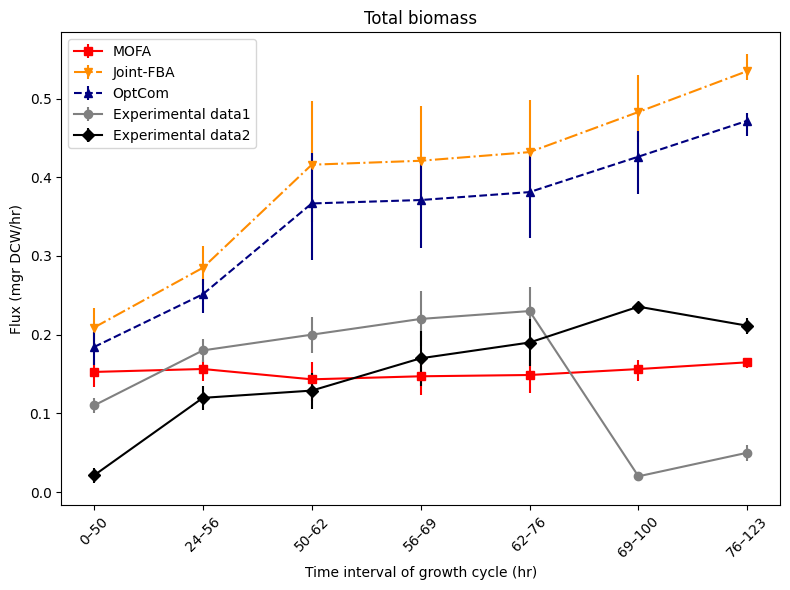

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

x_labels = ['0–50', '24–56', '50–62', '56–69', '62–76', '69–100', '76–123']
x = np.arange(len(x_labels))

avg_experience1 = np.array([0.11, 0.18, 0.2, 0.22, 0.23,0.02, 0.05])
error_exp1 = np.array([0.01, 0.015, 0.023, 0.035, 0.03, 0, 0.01])

avg_experience2 = np.array([0.0211395833333334, 0.119695095486111, 0.12892693236715, 0.1699775, 0.190022988505747,0.235569664902998, 0.21138268321513])


optcom_upper=np.array([0.2032869319, 0.2706559387, 0.4310671379, 0.4247889466, 0.4314571819,0.4592036302, 0.4819531351])
optcom_lower=np.array([0.1615032392,0.2270504928,0.2950855296,0.3100100008, 0.323272392,0.3785086418, 0.4523763691])
optcom_avg=np.array([0.184237698825,0.251366811168,0.3667472981,0.3711052514,0.3811753, 0.4262285222,0.4718857434])

Joint_fba_upper=np.array([0.183533613445378,0.257815384615385,0.335257383966245,0.351710416666667,0.366279918864097,0.435664246823956,0.513073770491803])
Joint_fba_lower=np.array([0.230953781512605,0.306923076923077,0.48884388185654,0.48151875,0.488957403651116,0.520693284936479,0.546401639344262])
Joint_fba_avg=np.array([0.209,0.285,0.416,0.421,0.432,0.483,0.535])

# Calculate the symmetric error bars
err_our = np.vstack((abs(our_lower-our_avg), abs(our_upper-our_avg)))
err_optcom = np.vstack((abs(optcom_lower-optcom_avg), abs(optcom_upper-optcom_avg)))
err_joint = np.vstack((abs(Joint_fba_lower-Joint_fba_avg), abs(Joint_fba_upper-Joint_fba_avg)))

plt.figure(figsize=(8, 6))

# darkorange line
plt.errorbar(x, our_avg, yerr=err_our, fmt='-s', color='red', label='MOFA')

# navy line
plt.errorbar(x, Joint_fba_avg, yerr=err_joint, fmt='-.v', color='darkorange', label='Joint-FBA')

plt.errorbar(x, optcom_avg, yerr=err_optcom, fmt='--^', color='navy', label='OptCom')


# Gray line
plt.errorbar(x, avg_experience1, yerr=error_exp1, fmt='-o', color='gray', label='Experimental data1')

# black line
plt.errorbar(x, avg_experience2, yerr=error_exp1, fmt='-D', color='black', label='Experimental data2')

plt.xticks(x, x_labels, rotation=45)
plt.ylabel("Flux (mgr DCW/hr)")
plt.xlabel("Time interval of growth cycle (hr)")
plt.title("Total biomass")
plt.legend()
plt.tight_layout()
plt.savefig("Total_biomass_plot.png", dpi=600, bbox_inches='tight', format='png')  # or 'pdf' or 'svg'

plt.show()

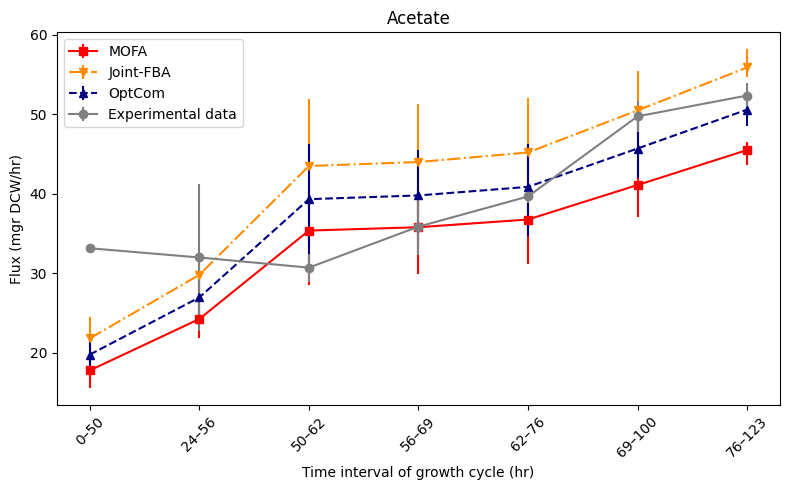

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

x_labels = ['0–50', '24–56', '50–62', '56–69', '62–76', '69–100', '76–123']
x = np.arange(len(x_labels))

avg_exp_Acetate = np.array([33.14544348, 31.98353556, 30.70601494, 35.86502918, 39.66264303,49.74872816, 52.36995247])
error_exp = np.array([0.53242154150707, 9.28560009261931, 1.76558287122238, 3.60391544382276, 0.884015205187326, 1.9551457157173, 1.56234231509156])

#avg_experience2 = np.array([0.0211395833333334, 0.119695095486111, 0.12892693236715, 0.1699775, 0.190022988505747,0.235569664902998, 0.21138268321513])


optcom_acetate_upper=np.array([ 21.79982,29.0211,46.22095,45.54953,46.26376,49.23638,51.67542])
optcom_acetate_lower=np.array([17.31935,24.34319,31.63902,33.24065,34.66175,41.94531,48.50362])
optcom_acetate_avg=np.array([19.75715,26.95166,39.32322,39.79302,40.87147,45.69989,50.59547])

Stolyar_acetate_upper=np.array([19.1436974789916,26.9575384615385,35.0569620253164,36.7583333333333,38.3237322515213,45.5508166969147,53.6090163934426])
Stolyar_acetate_lower=np.array([24.0899159663866,32.0923076923077,51.1170886075949,50.325,51.1594320486815,54.4410163339383,57.0913114754098])
Stolyar_acetate_avg=np.array([21.8,29.8,43.5,44,45.2,50.5,55.9])

# Calculate the symmetric error bars
err_our = np.vstack((abs(Acetate_lb-Acetate_avg), abs(Acetate_ub-Acetate_avg)))
err_optcom = np.vstack((abs(optcom_acetate_lower-optcom_acetate_avg), abs(optcom_acetate_upper-optcom_acetate_avg)))
err_joint = np.vstack((abs(Stolyar_acetate_lower-Stolyar_acetate_avg), abs(Stolyar_acetate_upper-Stolyar_acetate_avg)))

plt.figure(figsize=(8, 5))

# darkorange line
plt.errorbar(x, Acetate_avg, yerr=err_our, fmt='-s', color='red', label='MOFA')

# navy line
plt.errorbar(x, Stolyar_acetate_avg, yerr=err_joint, fmt='-.v', color='darkorange', label='Joint-FBA')

plt.errorbar(x, optcom_acetate_avg, yerr=err_optcom, fmt='--^', color='navy', label='OptCom')


# Gray line
plt.errorbar(x, avg_exp_Acetate, yerr=error_exp, fmt='-o', color='gray', label='Experimental data')

# black line
#plt.errorbar(x, avg_experience2, yerr=error_exp1, fmt='-D', color='black', label='Experimental data2')

plt.xticks(x, x_labels, rotation=45)
plt.ylabel("Flux (mgr DCW/hr)")
plt.xlabel("Time interval of growth cycle (hr)")
plt.title("Acetate")
plt.legend()
plt.tight_layout()
plt.savefig("Acetate_plot.png", dpi=600, bbox_inches='tight', format='png')  # or 'pdf' or 'svg'
plt.show()

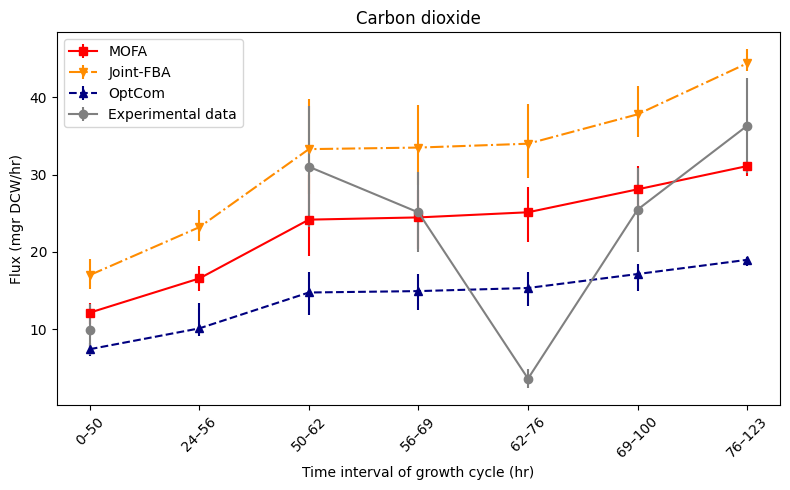

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

x_labels = ['0–50', '24–56', '50–62', '56–69', '62–76', '69–100', '76–123']
x = np.arange(len(x_labels))

avg_exp_CO2 = np.array([9.945020371,np.nan ,31.02021609,25.10951644,3.609478539,25.47412214,36.3211251])
error_exp = np.array([3.25810035223517,np.nan ,7.85046943888843,5.1752597050653,1.1925890951067,5.43040701015447,6.14064201102028])


optcom_co2_upper=np.array([ 8.18302,13.45328,17.3405,17.09179,17.35835,18.46909,19.38365])
optcom_co2_lower=np.array([6.50168,9.12878,11.86738,12.47073,13.00215,15.00507,18.19291])
optcom_co2_avg=np.array([7.41647,10.1095,14.75077,14.93159,15.33383,17.14097,18.97764])

Stolyar_co2_upper=np.array([14.9285714285714,20.9870769230769,26.8367088607595,27.9864583333333,28.8275862068966,34.0954627949183,42.5803278688525])
Stolyar_co2_lower=np.array([18.7857142857143,24.9846153846154,39.1310126582278,38.315625,38.4827586206897,40.7499092558984,45.3462295081967])
Stolyar_co2_avg=np.array([17,23.2,33.3,33.5,34,37.8,44.4])

# Calculate the symmetric error bars
err_our = np.vstack((abs(Carbon_dioxide_lb-Carbon_dioxide_avg), abs(Carbon_dioxide_ub-Carbon_dioxide_avg)))
err_optcom = np.vstack((abs(optcom_co2_lower-optcom_co2_avg), abs(optcom_co2_upper-optcom_co2_avg)))
err_joint = np.vstack((abs(Stolyar_co2_lower-Stolyar_co2_avg), abs(Stolyar_co2_upper-Stolyar_co2_avg)))

plt.figure(figsize=(8, 5))

# darkorange line
plt.errorbar(x, Carbon_dioxide_avg, yerr=err_our, fmt='-s', color='red', label='MOFA')

# navy line
plt.errorbar(x, Stolyar_co2_avg, yerr=err_joint, fmt='-.v', color='darkorange', label='Joint-FBA')

plt.errorbar(x, optcom_co2_avg, yerr=err_optcom, fmt='--^', color='navy', label='OptCom')


# Gray line
plt.errorbar(x, avg_exp_CO2, yerr=error_exp, fmt='-o', color='gray', label='Experimental data')

# black line
#plt.errorbar(x, avg_experience2, yerr=error_exp1, fmt='-D', color='black', label='Experimental data2')

plt.xticks(x, x_labels, rotation=45)
plt.ylabel("Flux (mgr DCW/hr)")
plt.xlabel("Time interval of growth cycle (hr)")
plt.title("Carbon dioxide")
plt.legend()
plt.tight_layout()
plt.savefig("Carbon_dioxide_plot.png", dpi=600, bbox_inches='tight', format='png')
plt.show()

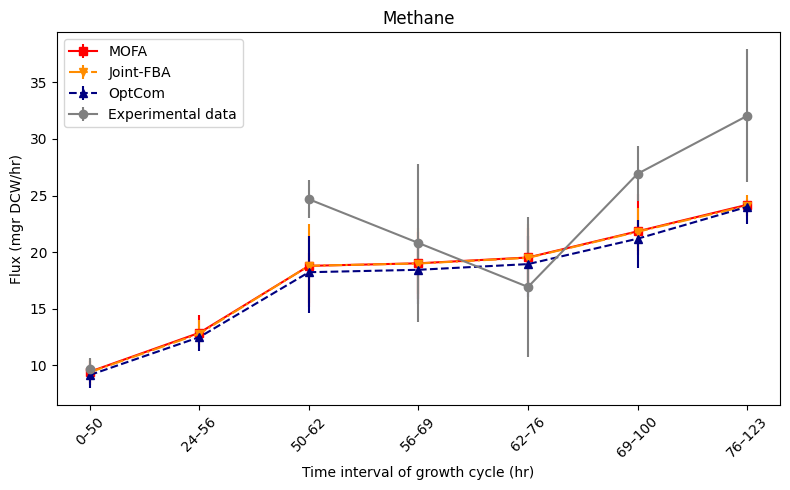

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

x_labels = ['0–50', '24–56', '50–62', '56–69', '62–76', '69–100', '76–123']
x = np.arange(len(x_labels))

avg_exp_ch4 = np.array([9.728443798,np.nan ,24.67293199,20.81207465,16.92927857,26.91921723,32.03255573])
error_exp = np.array([0.953952467114915,np.nan,1.68911684771614,7.01326575500656,6.16694440651839,2.42619026590158,5.87847855781387])


optcom_ch4_upper=np.array([ 10.10186,13.02826,21.42702,21.11289,21.44525,22.82734,23.95847])
optcom_ch4_lower=np.array([8.0252,11.28853,14.6694,15.40965,16.07,18.61419,22.48881])
optcom_ch4_avg=np.array([9.15512,12.49585,18.23113,18.44479,18.94688,21.18913,24])

Stolyar_ch4_upper=np.array([8.2546218487395,11.5790769230769,15.1510548523207,15.8729166666667,16.5334685598377,19.6635208711434,23.1122950819672])
Stolyar_ch4_lower=np.array([10.3873949579832,13.7846153846154,22.0919831223629,21.73125,22.0709939148073,23.5012704174229,24.613606557377])
Stolyar_ch4_avg=np.array([9.4,12.8,18.8,19,19.5,21.8,24.1])

# Calculate the symmetric error bars
err_our = np.vstack((abs(Methane_lb-Methane_avg), abs(Methane_ub-Methane_avg)))
err_optcom = np.vstack((abs(optcom_ch4_lower-optcom_ch4_avg), abs(optcom_ch4_upper-optcom_ch4_avg)))
err_joint = np.vstack((abs(Stolyar_ch4_lower-Stolyar_ch4_avg), abs(Stolyar_ch4_upper-Stolyar_ch4_avg)))

plt.figure(figsize=(8, 5))

# darkorange line
plt.errorbar(x, Methane_avg, yerr=err_our, fmt='-s', color='red', label='MOFA')

# navy line
plt.errorbar(x, Stolyar_ch4_avg, yerr=err_joint, fmt='-.v', color='darkorange', label='Joint-FBA')

plt.errorbar(x, optcom_ch4_avg, yerr=err_optcom, fmt='--^', color='navy', label='OptCom')


# Gray line
plt.errorbar(x, avg_exp_ch4, yerr=error_exp, fmt='-o', color='gray', label='Experimental data')

# black line
#plt.errorbar(x, avg_experience2, yerr=error_exp1, fmt='-D', color='black', label='Experimental data2')

plt.xticks(x, x_labels, rotation=45)
plt.ylabel("Flux (mgr DCW/hr)")
plt.xlabel("Time interval of growth cycle (hr)")
plt.title("Methane")
plt.legend()
plt.tight_layout()
plt.savefig("Methane_plot.png", dpi=600, bbox_inches='tight', format='png')
plt.show()

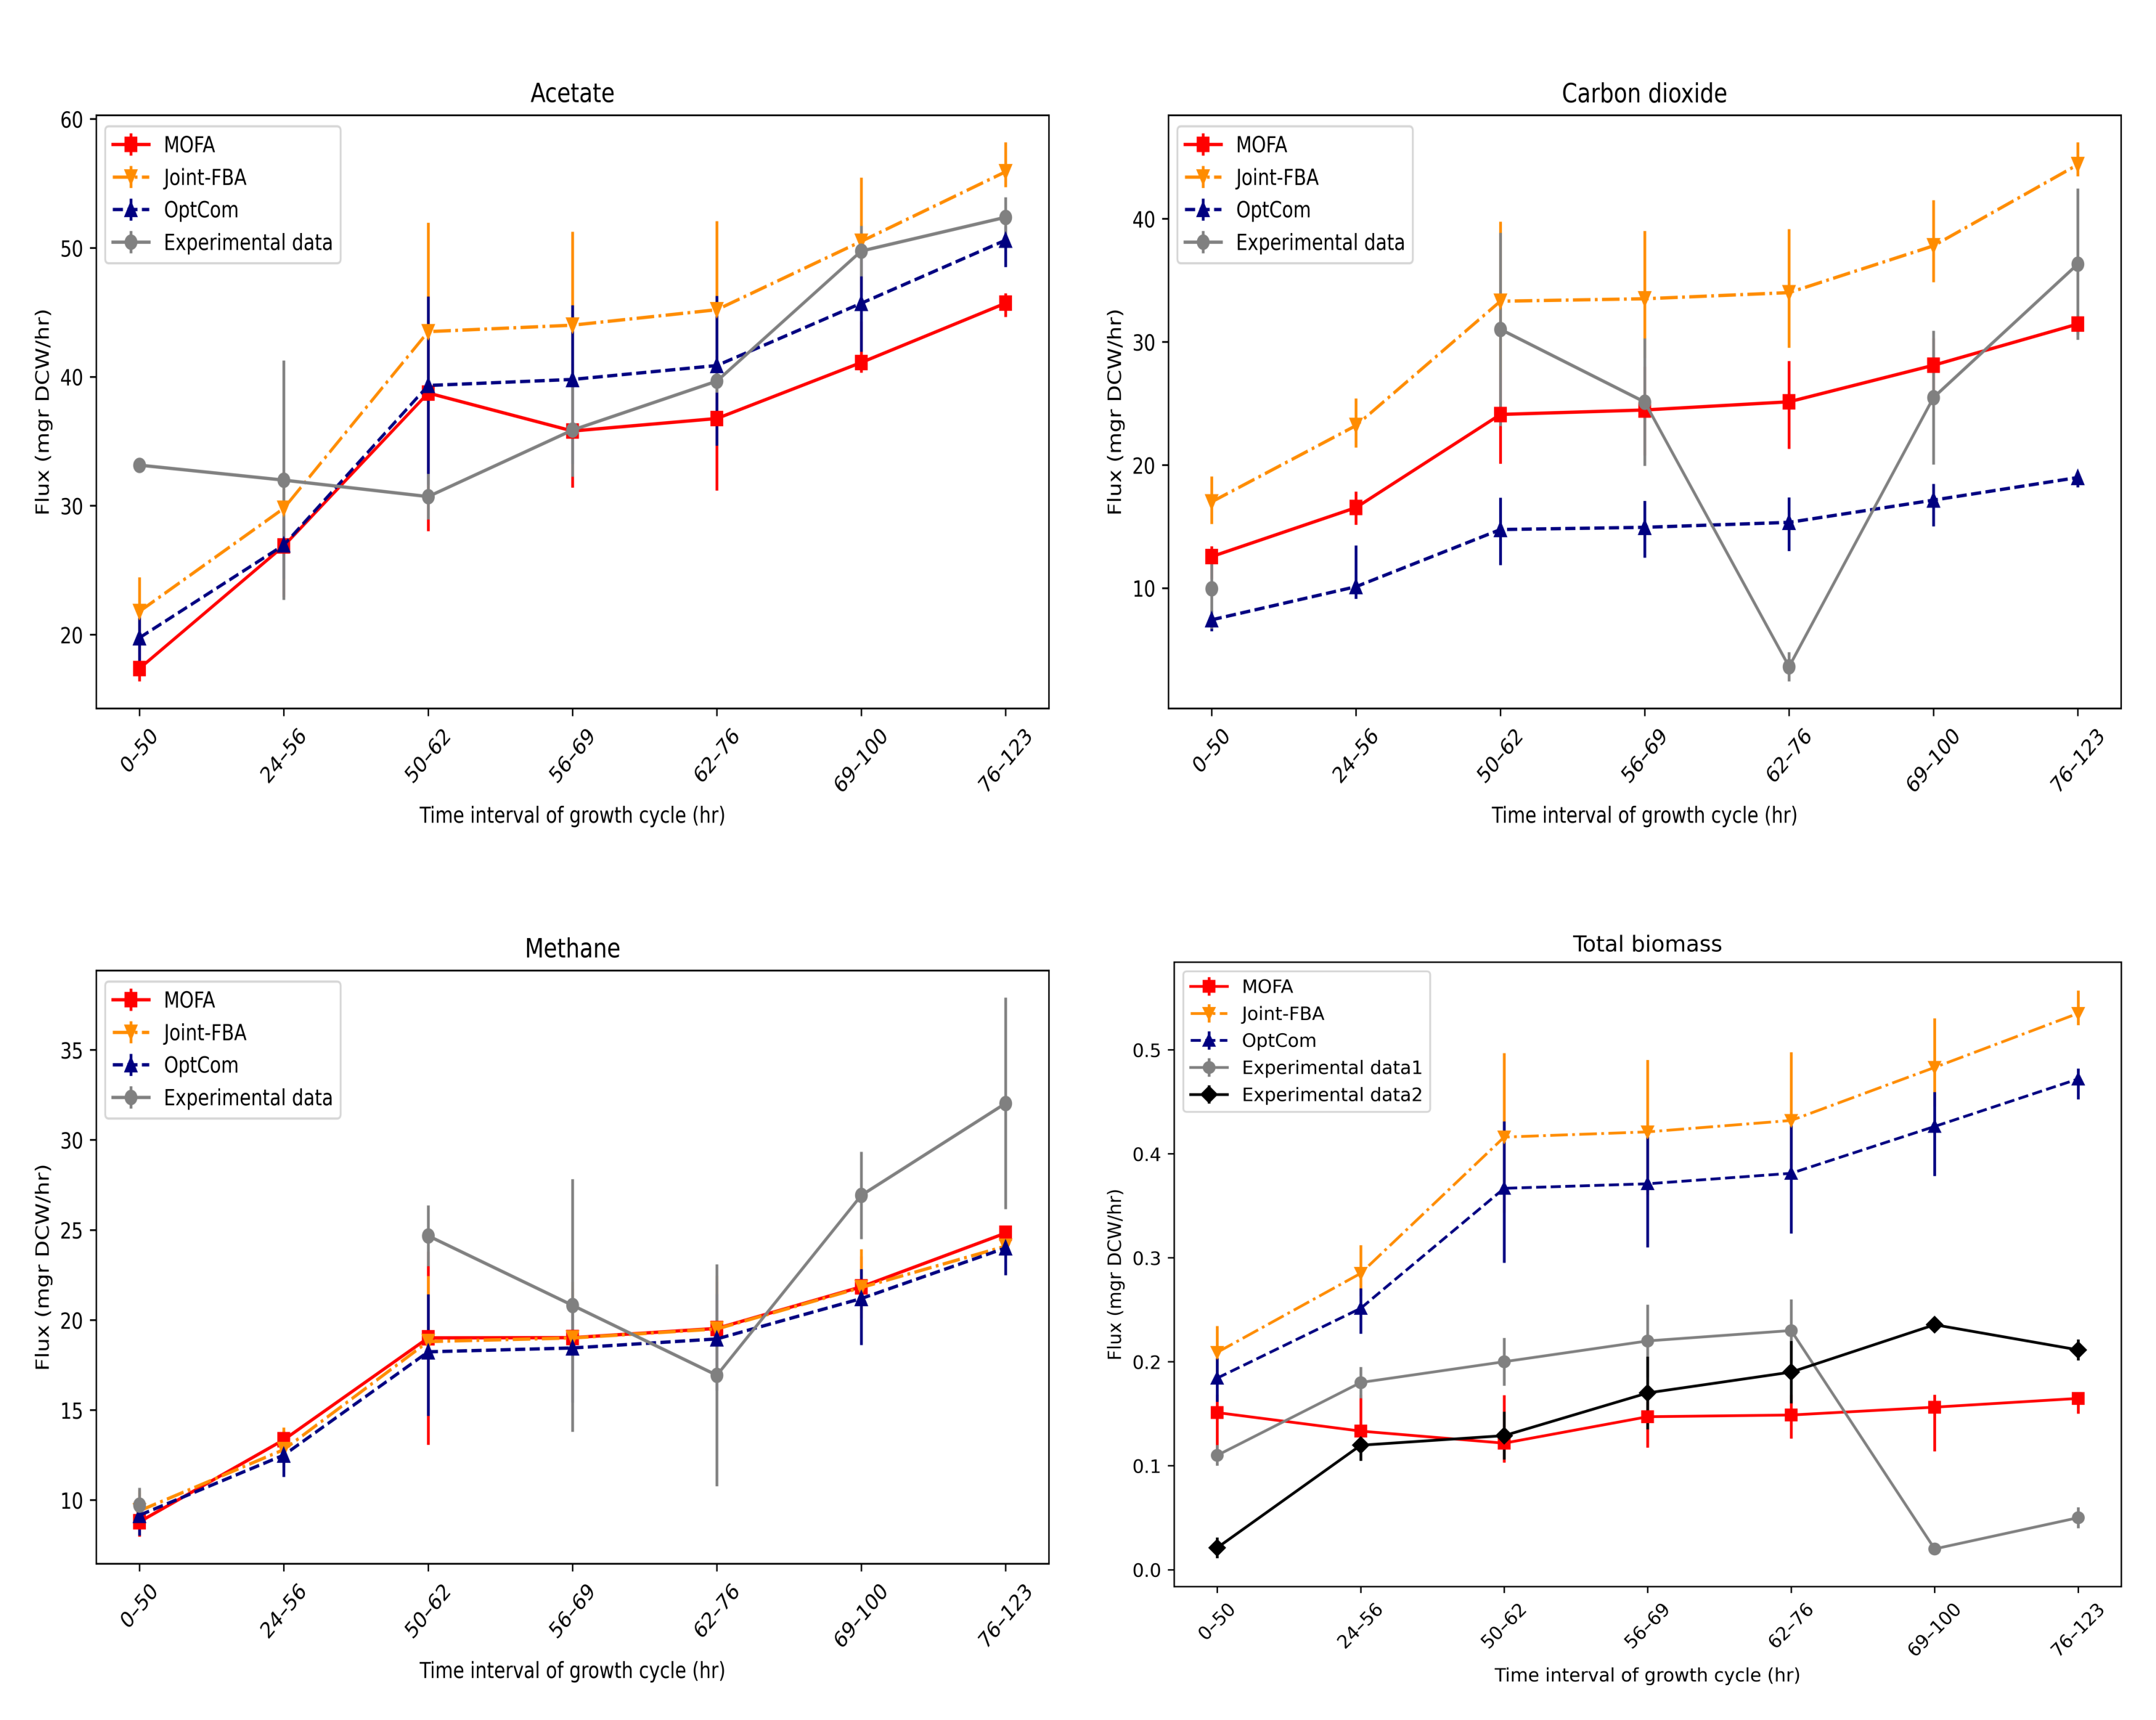

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig, axs = plt.subplots(2, 2, figsize=(10, 8), dpi=300)

images = [
    ("Acetate_plot.png", ""),
    ("Carbon_dioxide_plot.png", " "),
    ("Methane_plot.png", ""),
    ("Total_biomass_plot.png", " ")
]

for ax, (img, title) in zip(axs.flatten(), images):
    ax.imshow(mpimg.imread(img), aspect='auto')
    ax.set_title(title)
    ax.axis("off")

plt.tight_layout()
plt.savefig(
    "combined_figure.png",
    dpi=600,                # very high resolution
    bbox_inches="tight"
)

plt.show()

In [ ]:
mae1 = np.mean(np.abs(Acetate_avg - avg_exp_Acetate))
mae1

optcom = np.mean(np.abs(optcom_acetate_avg - avg_exp_Acetate))
optcom


joint_fba = np.mean(np.abs(Stolyar_acetate_avg - avg_exp_Acetate))
joint_fba
print(mae1,' ',optcom,' ',joint_fba)

6.6085173548214895   5.428216074285714   6.32523018


In [ ]:
mask = ~np.isnan(avg_exp_CO2)

# Compute MAE only for valid (non-NaN) entries
mae1 = np.mean(np.abs(Carbon_dioxide_avg[mask] - avg_exp_CO2[mask]))
mae1

optcom = np.mean(np.abs(optcom_co2_avg[mask] - avg_exp_CO2[mask]))
optcom


joint_fba = np.mean(np.abs(Stolyar_co2_avg[mask] - avg_exp_CO2[mask]))
joint_fba

print(mae1,' ',optcom,' ',joint_fba)

6.507232627150729   11.062818600333335   11.420086886666665


In [ ]:
mask = ~np.isnan(avg_exp_ch4)

# Compute MAE only for valid (non-NaN) entries
mae1 = np.mean(np.abs(Methane_avg[mask] - avg_exp_ch4[mask]))
mae1

optcom = np.mean(np.abs(optcom_ch4_avg[mask] - avg_exp_ch4[mask]))
optcom


joint_fba = np.mean(np.abs(Stolyar_ch4_avg[mask] - avg_exp_ch4[mask]))
joint_fba

print(mae1,' ',optcom,' ',joint_fba)

3.9156190571604728   4.193775804666666   3.9393241379999986


In [ ]:
import numpy as np
avg_experience1 = np.array([0.11, 0.18, 0.2, 0.22, 0.23,0.02, 0.05])
mae1 = np.mean(np.abs(our_avg - avg_experience1))

avg_experience2 = np.array([0.0211395833333334, 0.119695095486111, 0.12892693236715, 0.1699775, 0.190022988505747,0.235569664902998, 0.21138268321513])
mae2 = np.mean(np.abs(our_avg - avg_experience2))

print("mean absolute error: exp1:", mae1," mean absolute error: exp2:", mae2)
optcom_avg=np.array([0.184237698825,0.251366811168,0.3667472981,0.3711052514,0.3811753, 0.4262285222,0.4718857434])
mae1 = np.mean(np.abs(optcom_avg - avg_experience1))
mae2 = np.mean(np.abs(optcom_avg - avg_experience2))
print("\n OptCom mean absolute error: exp1:", mae1," mean absolute error: exp2:", mae2)

Joint_fba_avg=np.array([0.209,0.285,0.416,0.421,0.432,0.483,0.535])
mae1 = np.mean(np.abs(Joint_fba_avg - avg_experience1))
mae2 = np.mean(np.abs(Joint_fba_avg - avg_experience2))
print("\n JointFBA mean absolute error: exp1:", mae1," mean absolute error: exp2:", mae2)

mean absolute error: exp1: 0.07547300859388727  mean absolute error: exp2: 0.05320501643514354

 OptCom mean absolute error: exp1: 0.20610666072757144  mean absolute error: exp2: 0.19657602532607582

 JointFBA mean absolute error: exp1: 0.253  mean absolute error: exp2: 0.24346936459850438


In [ ]:
from scipy.stats import wilcoxon

statistic, p_value = wilcoxon(np.abs(optcom_avg-avg_experience1),np.abs(our_avg-avg_experience1 ), alternative='greater')

print("Wilcoxon statistic:", statistic)
print("p-value:", p_value)

statistic, p_value = wilcoxon(np.abs(optcom_avg-avg_experience2 ), np.abs(our_avg-avg_experience2),alternative='greater')

print("Wilcoxon statistic:", statistic)
print("p-value:", p_value)

Wilcoxon statistic: 28.0
p-value: 0.0078125
Wilcoxon statistic: 28.0
p-value: 0.0078125


In [ ]:
from scipy.stats import wilcoxon

statistic, p_value = wilcoxon(np.abs(our_avg-avg_experience1 ),np.abs(optcom_avg-avg_experience1), alternative='less')

print("Wilcoxon statistic:", statistic)
print("p-value:", p_value)

statistic, p_value = wilcoxon( np.abs(our_avg-avg_experience2), np.abs(optcom_avg-avg_experience2 ),alternative='less')

print("Wilcoxon statistic:", statistic)
print("p-value:", p_value)

Wilcoxon statistic: 0.0
p-value: 0.0078125
Wilcoxon statistic: 0.0
p-value: 0.0078125


In [ ]:
from scipy.stats import wilcoxon

statistic, p_value = wilcoxon(np.abs(our_avg-avg_experience1 ),np.abs(Joint_fba_avg-avg_experience1), alternative='less')

print("Wilcoxon statistic:", statistic)
print("p-value:", p_value)

statistic, p_value = wilcoxon( np.abs(our_avg-avg_experience2), np.abs(Joint_fba_avg-avg_experience2 ),alternative='less')

print("Wilcoxon statistic:", statistic)
print("p-value:", p_value)

Wilcoxon statistic: 0.0
p-value: 0.0078125
Wilcoxon statistic: 0.0
p-value: 0.0078125


In [ ]:

statistic, p_value = wilcoxon(Joint_fba_avg-avg_experience1, np.abs(our_avg-avg_experience1),alternative='less')

print("Wilcoxon statistic:", statistic)
print("p-value:", p_value)

statistic, p_value = wilcoxon(Joint_fba_avg-avg_experience1, np.abs(our_avg-avg_experience1),alternative='greater')

print("Wilcoxon statistic:", statistic)
print("p-value:", p_value)

statistic, p_value = wilcoxon(optcom_avg-avg_experience1, np.abs(our_avg-avg_experience1),alternative='greater')

print("Wilcoxon statistic:", statistic)
print("p-value:", p_value)

Wilcoxon statistic: 28.0
p-value: 1.0
Wilcoxon statistic: 28.0
p-value: 0.0078125
Wilcoxon statistic: 28.0
p-value: 0.0078125


In [ ]:
Joint_fba_avg-avg_experience1

array([0.099, 0.105, 0.216, 0.201, 0.202, 0.463, 0.485])

In [ ]:
our_avg-avg_experience1

array([ 0.04109166, -0.04672426, -0.07832023, -0.07288815, -0.08124595,
        0.13629635,  0.11472071])